In [8]:
%matplotlib inline
#!/opt/antelope/5.4/bin/python
import numpy as np
from obspy.core import utcdatetime
#from obspy.neic.client import Client
from obspy.clients.neic.client import Client
from obspy.io.xseed import Parser
#from obspy.core.util import gps2DistAzimuth
from obspy.geodetics import gps2dist_azimuth as gps2DistAzimuth
#from obspy.taup import TauPyModel
from obspy.signal import invsim as inv
from obspy.io.xseed.utils import SEEDParserException
# plot all traces into one pdf file
from matplotlib.backends.backend_pdf import PdfPages
# we will use dataless seed from IRIS to get station information
parser = Parser("../../AU.dataless")
# travel-time model will be iasp91 but could be any
#model = TauPyModel(model="iasp91")
from obspy.taup.taup import getTravelTimes
r_earth = 6371
def sind(x): return np.sin(x / 180. * np.pi)
def cosd(x): return np.cos(x / 180. * np.pi)
def tand(x): return np.tan(x / 180. * np.pi)
def arcsind(x): return np.arcsin(x) / np.pi * 180
def arccosd(x): return np.arccos(x) / np.pi * 180
def arctand(x): return np.arctan(x) / np.pi * 180
def gps2DistDegree(lat1, lon1, lat2, lon2):
    return arccosd(sind(lat1) * sind(lat2) +
                   cosd(lat1) * cosd(lat2) * cosd(lon1 - lon2))

In [9]:
# here we define how we measure peak to peak amplitude and period
def max_p2t(data, delta):
     """
     Function to find the maximum peak-to-trough amplitude and period of this \
     amplitude.

     :type data: ndarray
     :param data: waveform trace to find the peak-to-trough in.
     :type delta: float
     :param delta: Sampling interval in seconds

     :returns: tuple of (amplitude, period, time) with amplitude in the same \
         scale as given in the input data, and period in seconds, and time in \
         seconds from the start of the data window.
     """
     turning_points = []  # A list of tuples of (amplitude, sample)
     for i in range(1, len(data) - 1):
         if (data[i] < data[i-1] and data[i] < data[i+1]) or\
            (data[i] > data[i-1] and data[i] > data[i+1]):
             turning_points.append((data[i], i))
     if len(turning_points) >= 1:
         amplitudes = np.empty([len(turning_points)-1],)
         half_periods = np.empty([len(turning_points)-1],)
     else:
         print('Turning points has length: '+str(len(turning_points)) +
               ' data have length: '+str(len(data)))
         return (0.0, 0.0, 0.0)
     for i in range(1, len(turning_points)):
         half_periods[i-1] = (delta * (turning_points[i][1] -
                                       turning_points[i-1][1]))
         amplitudes[i-1] = np.abs(turning_points[i][0]-turning_points[i-1][0])
     amplitude = np.max(amplitudes)
     period = 2 * half_periods[np.argmax(amplitudes)]

     return (amplitude, period, delta*turning_points[np.argmax(amplitudes)][1])

In [10]:
# initialize the cwb port
client=Client(host='10.7.161.60',port=2061,debug=False)
eq=[]
# here we read all events line by line

USGS,tele,None,Preferred,2010,4,20,0,17,8,AWST,8,121.653,30.53,10,N,Mb,5.2,,13.3,,H,,18,0.87,,162,,5.531,,"NNE of Kalgoorlie, WA",Mb 5.2 USGS
sample rate 40.0


/nas/users/u61092/unix/.local/lib/python2.7/site-packages/ipykernel/__main__.py:67: ObsPyDeprecationWarning: 'getCoordinates' has been renamed to 'get_coordinates'. Use that instead.
/nas/users/u61092/unix/.local/lib/python2.7/site-packages/ipykernel/__main__.py:69: ObsPyDeprecationWarning: The getTravelTimes() function is deprecated. Please use the obspy.taup.TauPyModel class directly.


ARMA BHE 1.0 691007.289044 None
sample rate 40.0
ARMA BHN 1.0 691007.289044 None
sample rate 40.0
ARMA BHZ 1.0 691007.289044 None
sample rate 40.0
AS31 BHE 1.0 691007.289044 None
sample rate 40.0
AS31 BHN 1.0 691007.289044 None
sample rate 40.0
AS31 BHZ 1.0 691007.289044 None
sample rate 40.0
BBOO BHE 1.0 691007.289044 None
sample rate 40.0
BBOO BHN 1.0 691007.289044 None
sample rate 40.0
BBOO BHZ 1.0 691007.289044 None
sample rate 40.0
BLDU BHE 1.0 691007.289044 None
sample rate 40.0
BLDU BHN 1.0 691007.289044 None


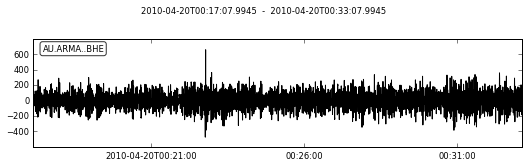

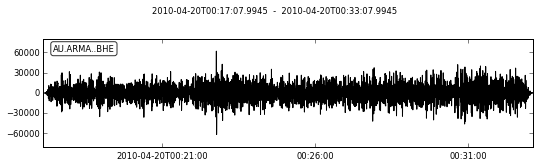

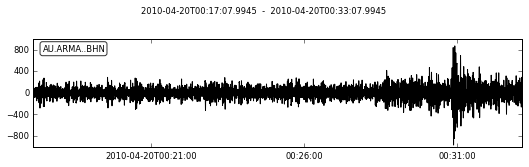

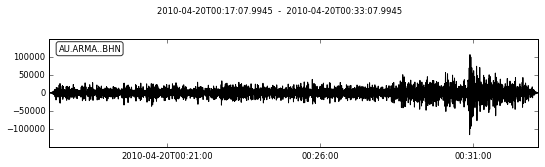

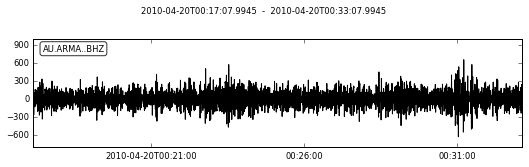

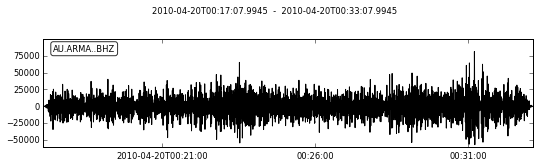

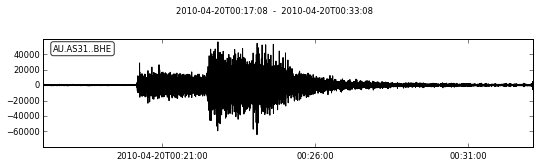

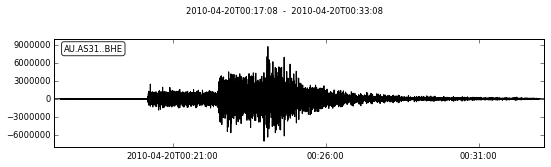

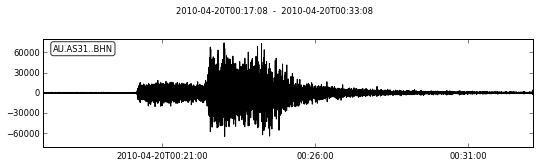

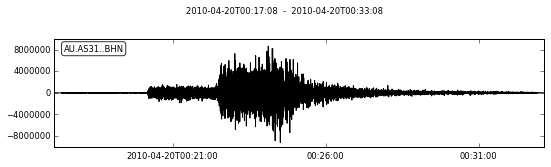

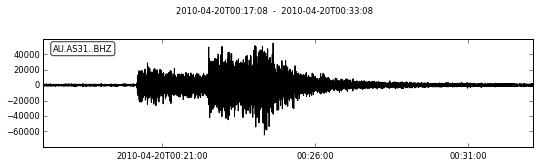

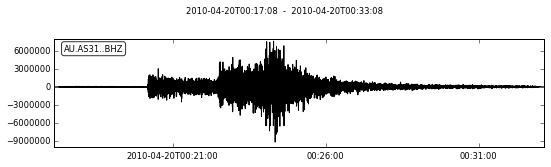

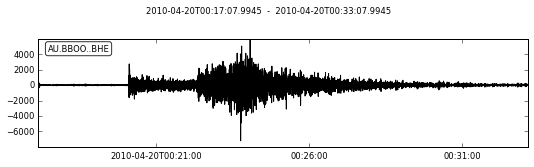

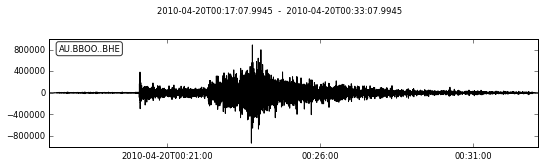

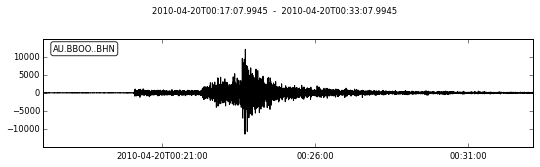

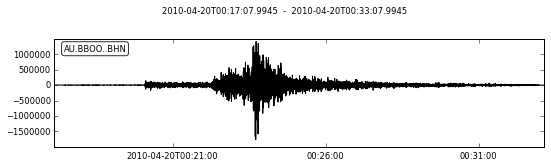

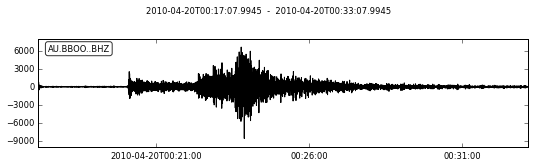

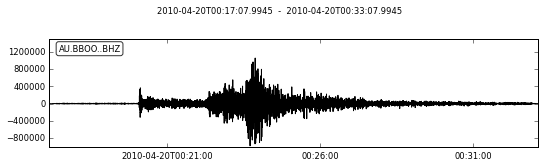

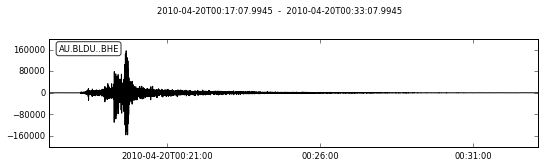

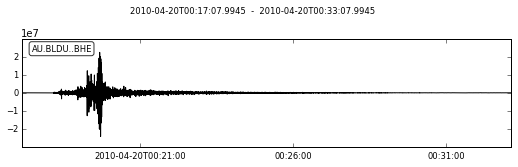

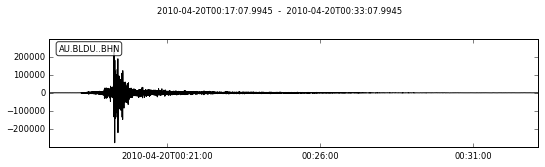

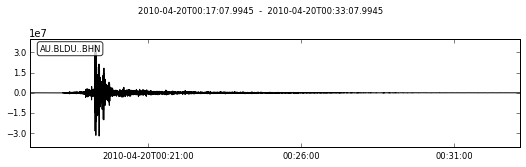

In [46]:
with open("../../eq2.txt",'r') as cat:
    for line in cat:
        eq=line.split(',')
        yr=int(eq[4])
        mon=int(eq[5])
        day=int(eq[6])
        hr=int(eq[7])
        mn=int(eq[8])
        sec=float(eq[9])
        code=eq[10]
        corr=float(eq[11])
        lon=float(eq[12])
        lat=float(eq[13])
        dep=float(eq[14])

        start_time=utcdatetime.UTCDateTime(yr,mon,day,hr,mn,int(sec),int((sec-int(sec))*100000))
#        ''' correct the time if not UTC '''
# Is this really needed??? Looks like may already be converted??
#        if code=="AEST" :
#            start_time-=36000
#        if code=="WITA" or code=="AWST":
#            start_time-=28800


        ''' the time window to request the data will be 20 minutes, check maximum travel time and increase this value accordingly '''
        end_time=start_time+960 # 16 minutes
        ''' get all waveform data available, use wildcards to reduce the data volume and speedup the process,
        unfortunately we need to request few times for every number of characters that forms the station name '''
        st_3 = client.get_waveforms("AU", "???", "", "[BS]??", start_time,end_time)
        st_4 = client.get_waveforms("AU", "????", "", "[BS]??", start_time,end_time)
        if len(st_4) > 0:
            st=st_3+st_4
        else:
            st=st_3

        # Cleanup duplicate traces returned by server
 #       st.merge(-1) #-1 method only merges overlapping or adjacent traces with same i            
        # Now sort the streams by station and channel
        st.sort()
        # Cleanup duplicate traces returned by server
        st.merge(1, fill_value=None) #1 method only merges overlapping or adjacent traces with same id
        # Now sort the streams by station and channel
        st.sort()
        
        # Filter the stream - should it be done here on by trace???
  #      st.filter(bandpass, freqmin=0.5, freqmax=10., )
        # PDF file to plot all traces for this event
        figpdf = PdfPages('test.pdf')

        ''' first we will print the record of the earthquake as in catalogue '''
        print line
        
        counter = 0 # For debugging only
        for tr in st:
            counter +=1
            ''' get station ID'''
            seedid=tr.get_id()
#            numobs = tr.count()
#            print 'count', numobs
#            print 'seedid', seedid
            print 'sample rate', tr.stats.sampling_rate
            sample_rate = tr.stats.sampling_rate
            # Filter the trace
            tr.filter('bandpass', freqmin=0.5, freqmax=10., corners=6)#, df=sample_rate)
            try:
                ''' get station coordinates from dataless seed '''
                tr.stats.coordinates = parser.getCoordinates(seedid,start_time)
                tr.stats.distance =gps2DistDegree(tr.stats.coordinates.latitude,tr.stats.coordinates.longitude,lat,lon)
                travel_times=getTravelTimes(tr.stats.distance,dep,model="iasp91")
                try:
                   arrivals= (item for item in travel_times if item["phase_name"]=='S' or item["phase_name"]=='Sn').next()
                except StopIteration:
                   print "WARNING: reference station ",tr.stats['station']," does not have S or Sn phases"
                figure = tr.plot(handle=True)
                try:
                    figpdf.savefig(figure)
                    figure.close()
                except:
                    pass
               # figpdf.close()
#                  print travel_times
                ''' lets select 20 seconds window from S-wave p2p measurements '''
#               print start_time+arrivals['time'],start_time+arrivals['time']+20,end_time
 #               wave=tr.slice(start_time+arrivals['time'],start_time+arrivals['time']+20)
 #               if len(wave.data)>0:
 #                  amplitude,period,delay=max_p2t(wave.data,wave.stats.delta)
 #               else:
 #                   amplitude,period,delay = None,None,None
 #               if amplitude > 0. and period > 0. :
                paz=parser.get_paz(seedid,start_time)
                ''' calib is already applied therefore we set sensitivity to 1 '''
                paz['sensitivity']=1.
                # Define Wood Anderson paz based on Uhrhammer 1990 sensitivity of 2080
                # rather than theoretical 2800 as used by obpy
                # wa_amp=inv.estimateWoodAndersonAmplitude(paz,amplitude,period)
                paz_wa = {'sensitivity': 2080, 'zeros': [0j], 'gain': 1,
                          'poles': [-6.2832 - 4.7124j, -6.2832 + 4.7124j]}
                # Now convert to WA spectra
                wa_tr = tr.simulate(paz_remove=paz, paz_simulate=paz_wa)
                # Plot WA record
                figure = wa_tr.plot(handle=True)
                try:
                    figpdf.savefig(figure)
                    figure.close()
                except:
                    pass
                # Calculate WA amplitudes and periods
                wave=wa_tr.slice(start_time+arrivals['time'],start_time+arrivals['time']+20)
                if len(wave.data)>0:
                    wa_amp,period,delay=max_p2t(wave.data,wave.stats.delta)
                else:
                    amplitude,period,delay = None,None,None
                ''' now we print every station-component measurement '''
                print tr.stats['station'],tr.stats['channel'],tr.stats['calib'],wa_amp,period
                #else:
                #    print tr.stats['station'],tr.stats['channel'],tr.stats['calib'],amplitude,period
            except (SEEDParserException,AssertionError):
                print  tr.stats['station'],tr.stats['channel'],'-1,-1,-1'
            if counter > 10:
                break
    figpdf.close()